# Key Metrics and Anomaly Detection

In [1]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt


## Loading JSON Data

We'll load the public cases data from a JSON file for analysis and anomaly detection.

In [2]:
# Load the public cases JSON data
import json
import requests

url = "https://raw.githubusercontent.com/forking-shirtballs/Machine-Learning-Group-Project/5ca0c444c51ff33e3483d16080c2c297f70513fd/public_cases.json"
response = requests.get(url)
data = response.json()

print(f"Loaded {len(data)} records from public_cases.json")
print(f"Data type: {type(data)}")

# Display a sample of the data structure
if isinstance(data, list) and len(data) > 0:
    print(f"Sample record structure:")
    sample_str = json.dumps(data[0], indent=2)
    print(sample_str[:500] + "..." if len(sample_str) > 500 else sample_str)
elif isinstance(data, dict):
    print(f"Keys in data: {list(data.keys())}")
else:
    print(f"Data structure: {data}")

Loaded 1000 records from public_cases.json
Data type: <class 'list'>
Sample record structure:
{
  "input": {
    "trip_duration_days": 3,
    "miles_traveled": 93,
    "total_receipts_amount": 1.42
  },
  "expected_output": 364.51
}


In [3]:
# Convert JSON data to pandas DataFrame for easier analysis
if isinstance(data, list):
    # Convert list of dictionaries to DataFrame
    df = pd.json_normalize(data)
elif isinstance(data, dict):
    # If it's a dict, try to create DataFrame from values or normalize
    try:
        df = pd.json_normalize(data)
    except:
        df = pd.DataFrame([data])
else:
    print("Data format not suitable for DataFrame conversion")
    df = None

# Display basic information about the DataFrame

if df is not None:
    print(f"DataFrame shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print("\nFirst few rows:")
    display(df.head())
    
    print(f"\nData types:")
    print(df.dtypes)
    
    print(f"\nBasic statistics:")
    display(df.describe())

DataFrame shape: (1000, 4)
Columns: ['expected_output', 'input.trip_duration_days', 'input.miles_traveled', 'input.total_receipts_amount']

First few rows:


,expected_output,input.trip_duration_days,input.miles_traveled,input.total_receipts_amount
0,364.51,3,93.0,1.42
1,126.06,1,55.0,3.60
2,128.91,1,47.0,17.97
3,203.52,2,13.0,4.67
4,380.37,3,88.0,5.78



Data types:
expected_output                float64
input.trip_duration_days         int64
input.miles_traveled           float64
input.total_receipts_amount    float64
dtype: object

Basic statistics:


,expected_output,input.trip_duration_days,input.miles_traveled,input.total_receipts_amount
count,1000.000000,1000.000000,1000.00000,1000.00000
mean,1349.114030,7.043000,597.41374,1211.05687
std,470.316464,3.926139,351.29979,742.85418
min,117.240000,1.000000,5.00000,1.42000
25%,1019.297500,4.000000,275.96000,530.37750
50%,1454.260000,7.000000,621.00000,1171.90000
75%,1711.122500,10.000000,893.00000,1881.10500
max,2337.730000,14.000000,1317.07000,2503.46000


## Anomaly Detection on Public Cases Data

Now we'll perform various anomaly detection techniques on the loaded data to identify unusual patterns, outliers, and data quality issues.

In [4]:
# Check for missing values and data quality issues
if df is not None:
    print("=== DATA QUALITY ANALYSIS ===\n")
    
    # Missing values
    missing_counts = df.isnull().sum()
    if missing_counts.sum() > 0:
        print("Missing values by column:")
        for col, count in missing_counts[missing_counts > 0].items():
            print(f"  {col}: {count} ({count/len(df)*100:.1f}%)")
    else:
        print("No missing values found.")
    
    print(f"\nDuplicate rows: {df.duplicated().sum()}")
    
    # Check for numeric columns and potential outliers
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print(f"\nNumeric columns for outlier detection: {list(numeric_cols)}")
        
        for col in numeric_cols:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
            
            if len(outliers) > 0:
                print(f"  {col}: {len(outliers)} potential outliers ({len(outliers)/len(df)*100:.1f}%)")
                print(f"    Range: {df[col].min():.2f} to {df[col].max():.2f}")
                print(f"    Outlier bounds: < {lower_bound:.2f} or > {upper_bound:.2f}")
    else:
        print("\nNo numeric columns found for outlier detection.")
        
    # Check string columns for unusual patterns
    string_cols = df.select_dtypes(include=['object']).columns
    if len(string_cols) > 0:
        print(f"\nString columns: {list(string_cols)}")
        for col in string_cols:
            unique_count = df[col].nunique()
            print(f"  {col}: {unique_count} unique values")
            
            # Check for unusually long/short strings
            if df[col].dtype == 'object':
                str_lengths = df[col].astype(str).str.len()
                if str_lengths.std() > 0:  # If there's variation in length
                    long_strings = df[str_lengths > str_lengths.quantile(0.95)]
                    short_strings = df[str_lengths < str_lengths.quantile(0.05)]
                    
                    if len(long_strings) > 0:
                        print(f"    Unusually long entries: {len(long_strings)}")
                    if len(short_strings) > 0:
                        print(f"    Unusually short entries: {len(short_strings)}")
else:
    print("No DataFrame available for analysis.")

=== DATA QUALITY ANALYSIS ===

No missing values found.

Duplicate rows: 0

Numeric columns for outlier detection: ['expected_output', 'input.trip_duration_days', 'input.miles_traveled', 'input.total_receipts_amount']


### Hierarchical Formats

In [8]:
# Using the public cases data we loaded earlier
print("Public cases data structure:")
print(f"Data type: {type(data)}")
print(f"Number of records: {len(data) if isinstance(data, list) else 'N/A'}")

# Show how JSON parsing works with real data
if isinstance(data, list) and len(data) > 0:
    # Show the first record as JSON string and then parsed
    first_record_json = json.dumps(data[0], indent=2)
    print(f"\nFirst record as JSON string (truncated):")
    print(first_record_json[:200] + "..." if len(first_record_json) > 200 else first_record_json)
    
    # Parse it back (demonstrating json.loads with real data)
    parsed_record = json.loads(json.dumps(data[0]))
    print(f"\nParsed back to Python object:")
    print(f"Keys: {list(parsed_record.keys()) if isinstance(parsed_record, dict) else 'Not a dict'}")

Public cases data structure:
Data type: <class 'list'>
Number of records: 1000

First record as JSON string (truncated):
{
  "input": {
    "trip_duration_days": 3,
    "miles_traveled": 93,
    "total_receipts_amount": 1.42
  },
  "expected_output": 364.51
}

Parsed back to Python object:
Keys: ['input', 'expected_output']


In [9]:
import json
import numpy as np

# Use the public cases data we already loaded
print("Analyzing public cases data structure:")
print(f"Working with {len(data)} records")

# Create a sample subset for demonstration
if isinstance(data, list) and len(data) > 0:
    # Take first few records to analyze
    sample_data = data[:5]  # First 5 records
    
    # Convert to JSON string and back to demonstrate JSON handling
    json_string = json.dumps(sample_data, indent=2)
    parsed_data = json.loads(json_string)
    
    print(f"Sample data structure:")
    display(parsed_data)
    
    # Analyze the structure
    if len(parsed_data) > 0:
        print(f"\nKeys in first record: {list(parsed_data[0].keys())}")
else:
    print("No suitable data structure found")

Analyzing public cases data structure:
Working with 1000 records
Sample data structure:


[{'input': {'trip_duration_days': 3,
   'miles_traveled': 93,
   'total_receipts_amount': 1.42},
  'expected_output': 364.51},
 {'input': {'trip_duration_days': 1,
   'miles_traveled': 55,
   'total_receipts_amount': 3.6},
  'expected_output': 126.06},
 {'input': {'trip_duration_days': 1,
   'miles_traveled': 47,
   'total_receipts_amount': 17.97},
  'expected_output': 128.91},
 {'input': {'trip_duration_days': 2,
   'miles_traveled': 13,
   'total_receipts_amount': 4.67},
  'expected_output': 203.52},
 {'input': {'trip_duration_days': 3,
   'miles_traveled': 88,
   'total_receipts_amount': 5.78},
  'expected_output': 380.37}]


Keys in first record: ['input', 'expected_output']


In [10]:
df.sort_index()

,expected_output,input.trip_duration_days,input.miles_traveled,input.total_receipts_amount
0,364.51,3,93.0,1.42
1,126.06,1,55.0,3.60
2,128.91,1,47.0,17.97
3,203.52,2,13.0,4.67
4,380.37,3,88.0,5.78
...,...,...,...,...
995,446.94,1,1082.0,1809.49
996,1699.94,11,636.0,2238.97
997,946.39,6,370.0,315.09
998,802.95,8,413.0,222.83


In [11]:
pd.json_normalize(data).sort_index()

,expected_output,input.trip_duration_days,input.miles_traveled,input.total_receipts_amount
0,364.51,3,93.0,1.42
1,126.06,1,55.0,3.60
2,128.91,1,47.0,17.97
3,203.52,2,13.0,4.67
4,380.37,3,88.0,5.78
...,...,...,...,...
995,446.94,1,1082.0,1809.49
996,1699.94,11,636.0,2238.97
997,946.39,6,370.0,315.09
998,802.95,8,413.0,222.83


In [12]:
# Check for missing or problematic values in the public cases data
print("Checking data quality in public cases:")
for idx, record in enumerate(data):
    # Check expected_output
    if 'expected_output' not in record:
        print(f"Record {idx}: Missing 'expected_output'")
    elif record['expected_output'] is None:
        print(f"Record {idx}: expected_output is None")
    elif isinstance(record['expected_output'], float) and math.isnan(record['expected_output']):
        print(f"Record {idx}: expected_output is NaN")
    
    # Check input fields
    if 'input' not in record:
        print(f"Record {idx}: Missing 'input'")
    else:
        for field in ['trip_duration_days', 'miles_traveled', 'total_receipts_amount']:
            if field not in record['input']:
                print(f"Record {idx}: Missing input field '{field}'")
            else:
                val = record['input'][field]
                if val is None:
                    print(f"Record {idx}: input.{field} is None")
                elif isinstance(val, float) and math.isnan(val):
                    print(f"Record {idx}: input.{field} is NaN")
                elif val == '' or val == 0:
                    print(f"Record {idx}: input.{field} has empty/zero value: {repr(val)}")

print("Data quality check complete.")

Checking data quality in public cases:
Data quality check complete.


### Sentinels

In [13]:
# Get min and max for 'expected_output' in the data list
expected_outputs = [record['expected_output'] for record in data if 'expected_output' in record and record['expected_output'] is not None]
trip_duration = [record['input']['trip_duration_days'] for record in data if 'input' in record and 'trip_duration_days' in record['input'] and record['input']['trip_duration_days'] is not None]
miles_traveled = [record['input']['miles_traveled'] for record in data if 'input' in record and 'miles_traveled' in record['input'] and record['input']['miles_traveled'] is not None]
receipt_amounts = [record['input']['total_receipts_amount'] for record in data if 'input' in record and 'total_receipts_amount' in record['input'] and record['input']['total_receipts_amount'] is not None]

pd.DataFrame([{
    'expected_output_min': min(expected_outputs) if expected_outputs else None,
    'expected_output_max': max(expected_outputs) if expected_outputs else None,
    'trip_duration_min': min(trip_duration) if trip_duration else None,
    'trip_duration_max': max(trip_duration) if trip_duration else None,
    'miles_traveled_min': min(miles_traveled) if miles_traveled else None,
    'miles_traveled_max': max(miles_traveled) if miles_traveled else None,
    'receipt_amounts_min': min(receipt_amounts) if receipt_amounts else None,
    'receipt_amounts_max': max(receipt_amounts) if receipt_amounts else None
}])

,expected_output_min,expected_output_max,trip_duration_min,trip_duration_max,miles_traveled_min,miles_traveled_max,receipt_amounts_min,receipt_amounts_max
0,117.24,2337.73,1,14,5,1317.07,1.42,2503.46


In [14]:
# Check the actual distribution of your data
for col in ['expected_output', 'input.trip_duration_days', 'input.miles_traveled', 'input.total_receipts_amount']:
    print(f"\n{col} distribution:")
    print(f"Min: {df[col].min()}")
    print(f"25th percentile: {df[col].quantile(0.25)}")
    print(f"Median: {df[col].quantile(0.50)}")
    print(f"75th percentile: {df[col].quantile(0.75)}")
    print(f"Max: {df[col].max()}")
    print(f"99th percentile: {df[col].quantile(0.99)}")
    print(f"Values > 999.9: {(df[col] > 999.9).sum()}")



expected_output distribution:
Min: 117.24
25th percentile: 1019.2975
Median: 1454.26
75th percentile: 1711.1225
Max: 2337.73
99th percentile: 2159.357
Values > 999.9: 754

input.trip_duration_days distribution:
Min: 1
25th percentile: 4.0
Median: 7.0
75th percentile: 10.0
Max: 14
99th percentile: 14.0
Values > 999.9: 0

input.miles_traveled distribution:
Min: 5.0
25th percentile: 275.96
Median: 621.0
75th percentile: 893.0
Max: 1317.07
99th percentile: 1189.02
Values > 999.9: 168

input.total_receipts_amount distribution:
Min: 1.42
25th percentile: 530.3775
Median: 1171.9
75th percentile: 1881.105
Max: 2503.46
99th percentile: 2488.2291
Values > 999.9: 566


Expected Output statistics:
count    1000.000000
mean     1349.114030
std       470.316464
min       117.240000
25%      1019.297500
50%      1454.260000
75%      1711.122500
max      2337.730000
dtype: float64

Smallest 5 expected outputs:
[117.24 120.65 126.06 128.91 150.34]

Largest 5 expected outputs:
[2337.73 2279.82 2248.12 2239.35 2214.64]


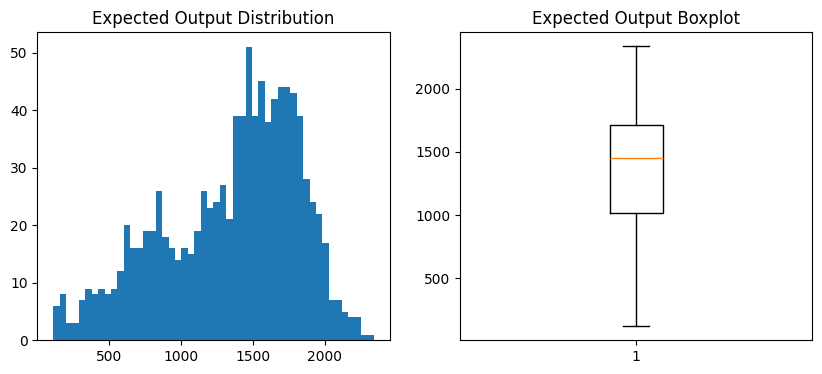

In [15]:
# Get descriptive statistics
print("Expected Output statistics:")
expected_outputs_series = pd.Series(expected_outputs)
print(expected_outputs_series.describe())

# Look at extreme values
print(f"\nSmallest 5 expected outputs:")
print(expected_outputs_series.nsmallest(5).values)

print(f"\nLargest 5 expected outputs:")
print(expected_outputs_series.nlargest(5).values)

# Visualize the distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(expected_outputs_series, bins=50)
plt.title("Expected Output Distribution")

plt.subplot(1, 2, 2)
plt.boxplot(expected_outputs_series)
plt.title("Expected Output Boxplot")
plt.show()

In [16]:
def detect_outliers_iqr(series, multiplier=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return (series < lower_bound) | (series > upper_bound)

# Detect outliers using IQR method
expected_output_outliers = detect_outliers_iqr(expected_outputs_series)
print(f"IQR: Found {expected_output_outliers.sum()} expected output outliers")
expected_output_outliers.any()  

def detect_outliers_zscore(series, threshold=3):
    z_scores = abs((series - series.mean()) / series.std())
    return z_scores > threshold

# Detect outliers using Z-score method
expected_output_outliers = detect_outliers_zscore(expected_outputs_series, threshold=3)
print(f"Z-score: Found {expected_output_outliers.sum()} expected output outliers (>3 std devs)")
expected_output_outliers.any()

IQR: Found 0 expected output outliers
Z-score: Found 0 expected output outliers (>3 std devs)


np.False_

Trip Duration statistics:
count    1000.000000
mean        7.043000
std         3.926139
min         1.000000
25%         4.000000
50%         7.000000
75%        10.000000
max        14.000000
dtype: float64

Smallest 5 expected outputs:
[1 1 1 1 1]

Largest 5 expected outputs:
[14 14 14 14 14]


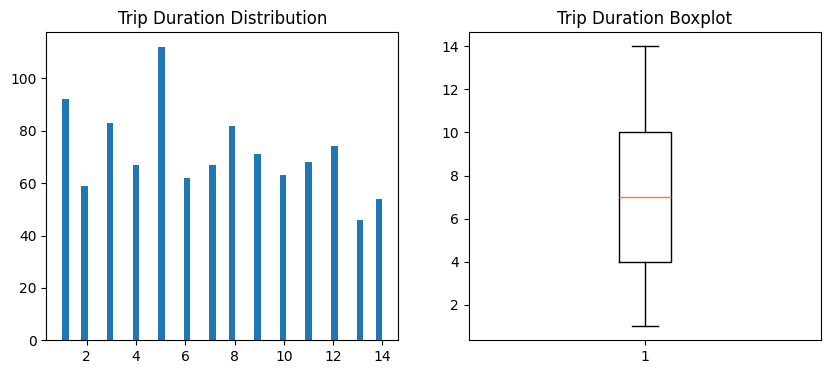

In [17]:
# Get descriptive statistics
print("Trip Duration statistics:")
trip_duration_series = pd.Series(trip_duration)
print(trip_duration_series.describe())

# Look at extreme values
print(f"\nSmallest 5 expected outputs:")
print(trip_duration_series.nsmallest(5).values)

print(f"\nLargest 5 expected outputs:")
print(trip_duration_series.nlargest(5).values)

# Visualize the distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(trip_duration_series, bins=50)
plt.title("Trip Duration Distribution")

plt.subplot(1, 2, 2)
plt.boxplot(trip_duration_series)
plt.title("Trip Duration Boxplot")
plt.show()

In [18]:
def detect_outliers_iqr(series, multiplier=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return (series < lower_bound) | (series > upper_bound)

# Detect outliers using IQR method
trip_duration_outliers = detect_outliers_iqr(trip_duration_series)
print(f"IQR: Found {trip_duration_outliers.sum()} trip duration outliers")
trip_duration_outliers.any()

# Detect outliers using Z-score method
trip_duration_outliers = detect_outliers_zscore(trip_duration_series, threshold=3)
print(f"Z-score: Found {trip_duration_outliers.sum()} trip duration outliers (>3 std devs)")
trip_duration_outliers.any()

IQR: Found 0 trip duration outliers
Z-score: Found 0 trip duration outliers (>3 std devs)


np.False_

Miles Traveled statistics:
count    1000.00000
mean      597.41374
std       351.29979
min         5.00000
25%       275.96000
50%       621.00000
75%       893.00000
max      1317.07000
dtype: float64

Smallest 5 expected outputs:
[5. 5. 5. 6. 7.]

Largest 5 expected outputs:
[1317.07 1204.   1203.   1202.   1199.  ]


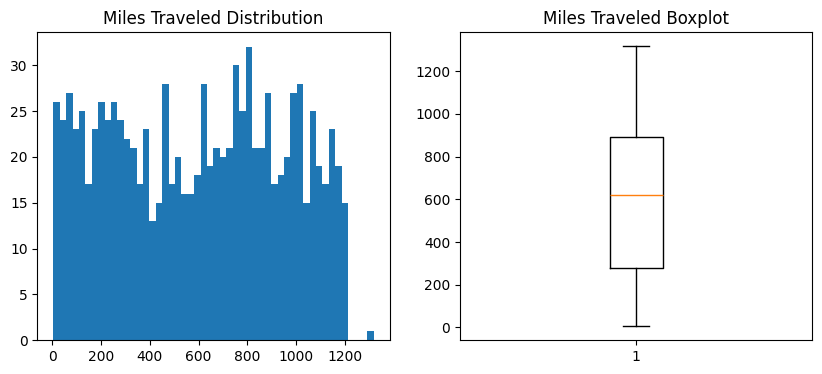

In [19]:
# Get descriptive statistics
print("Miles Traveled statistics:")
miles_traveled_series = pd.Series(miles_traveled)
print(miles_traveled_series.describe())

# Look at extreme values
print(f"\nSmallest 5 expected outputs:")
print(miles_traveled_series.nsmallest(5).values)

print(f"\nLargest 5 expected outputs:")
print(miles_traveled_series.nlargest(5).values)

# Visualize the distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(miles_traveled_series, bins=50)
plt.title("Miles Traveled Distribution")

plt.subplot(1, 2, 2)
plt.boxplot(miles_traveled_series)
plt.title("Miles Traveled Boxplot")
plt.show()

In [20]:
def detect_outliers_iqr(series, multiplier=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return (series < lower_bound) | (series > upper_bound)

# Detect outliers using IQR method
miles_traveled_outliers = detect_outliers_iqr(miles_traveled_series)
print(f"IQR: Found {miles_traveled_outliers.sum()} miles traveled outliers")
miles_traveled_outliers.any()

# Detect outliers using Z-score method
miles_traveled_outliers = detect_outliers_zscore(miles_traveled_series, threshold=3)
print(f"Z-score: Found {miles_traveled_outliers.sum()} miles traveled outliers (>3 std devs)")
miles_traveled_outliers.any()

IQR: Found 0 miles traveled outliers
Z-score: Found 0 miles traveled outliers (>3 std devs)


np.False_

Receipt Amounts statistics:
count    1000.00000
mean     1211.05687
std       742.85418
min         1.42000
25%       530.37750
50%      1171.90000
75%      1881.10500
max      2503.46000
dtype: float64

Smallest 5 expected outputs:
[1.42 3.6  4.52 4.67 5.78]

Largest 5 expected outputs:
[2503.46 2499.84 2497.93 2497.79 2497.16]


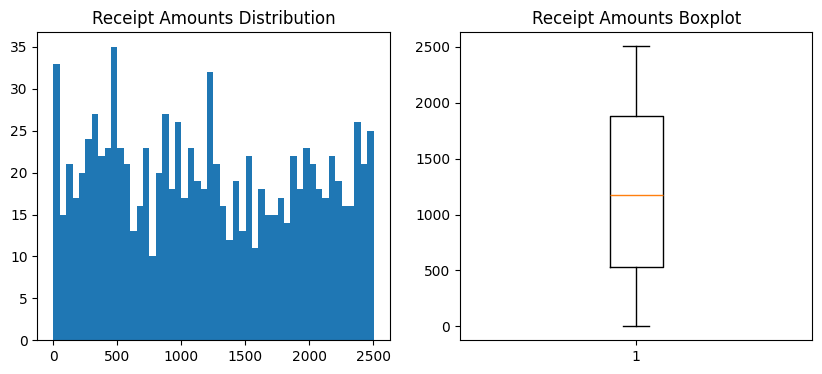

In [21]:
# Get descriptive statistics
print("Receipt Amounts statistics:")
receipt_amounts_series = pd.Series(receipt_amounts)
print(receipt_amounts_series.describe())

# Look at extreme values
print(f"\nSmallest 5 expected outputs:")
print(receipt_amounts_series.nsmallest(5).values)

print(f"\nLargest 5 expected outputs:")
print(receipt_amounts_series.nlargest(5).values)

# Visualize the distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(receipt_amounts_series, bins=50)
plt.title("Receipt Amounts Distribution")

plt.subplot(1, 2, 2)
plt.boxplot(receipt_amounts_series)
plt.title("Receipt Amounts Boxplot")
plt.show()

In [22]:
def detect_outliers_iqr(series, multiplier=1.5):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return (series < lower_bound) | (series > upper_bound)

# Detect outliers using IQR method
receipt_amounts_outliers = detect_outliers_iqr(receipt_amounts_series)
print(f"IQR: Found {receipt_amounts_outliers.sum()} receipt amounts outliers")
receipt_amounts_outliers.any()

# Detect outliers using Z-score method
receipt_amounts_outliers = detect_outliers_zscore(receipt_amounts_series, threshold=3)
print(f"Z-score: Found {receipt_amounts_outliers.sum()} receipt amounts outliers (>3 std devs)")
receipt_amounts_outliers.any()

IQR: Found 0 receipt amounts outliers
Z-score: Found 0 receipt amounts outliers (>3 std devs)


np.False_

In [23]:
from scipy.stats import zscore

# Compute Z-scores for each column in your dataframe
z_scores = df.apply(zscore)
display(z_scores)

,expected_output,input.trip_duration_days,input.miles_traveled,input.total_receipts_amount
0,-2.094540,-1.030280,-1.436568,-1.629179
1,-2.601793,-1.539941,-1.544792,-1.626243
2,-2.595730,-1.539941,-1.567576,-1.606889
3,-2.437013,-1.285111,-1.664408,-1.624801
4,-2.060801,-1.030280,-1.450808,-1.623306
...,...,...,...,...
995,-1.919187,-1.539941,1.380100,0.805989
996,0.746309,1.008365,0.109894,1.384427
997,-0.856712,-0.265788,-0.647673,-1.206718
998,-1.161850,0.243873,-0.525210,-1.330976


In [24]:
from scipy.stats import zscore

# Step 1: Compute Z-scores for each column
z_scores = df.apply(zscore)

# Step 2: Set a Z-score threshold for defining outliers
threshold = 3

# Step 3: Create a mask (True where value is an outlier)
outliers_mask = (z_scores.abs() > threshold)

# Step 4: Extract rows where any feature is an outlier
outliers = df[outliers_mask.any(axis=1)]

# Step 5: Print the outlier rows
print("Outlier rows (any value with |Z| > 3):")
print(outliers)


Outlier rows (any value with |Z| > 3):
Empty DataFrame
Columns: [expected_output, input.trip_duration_days, input.miles_traveled, input.total_receipts_amount]
Index: []


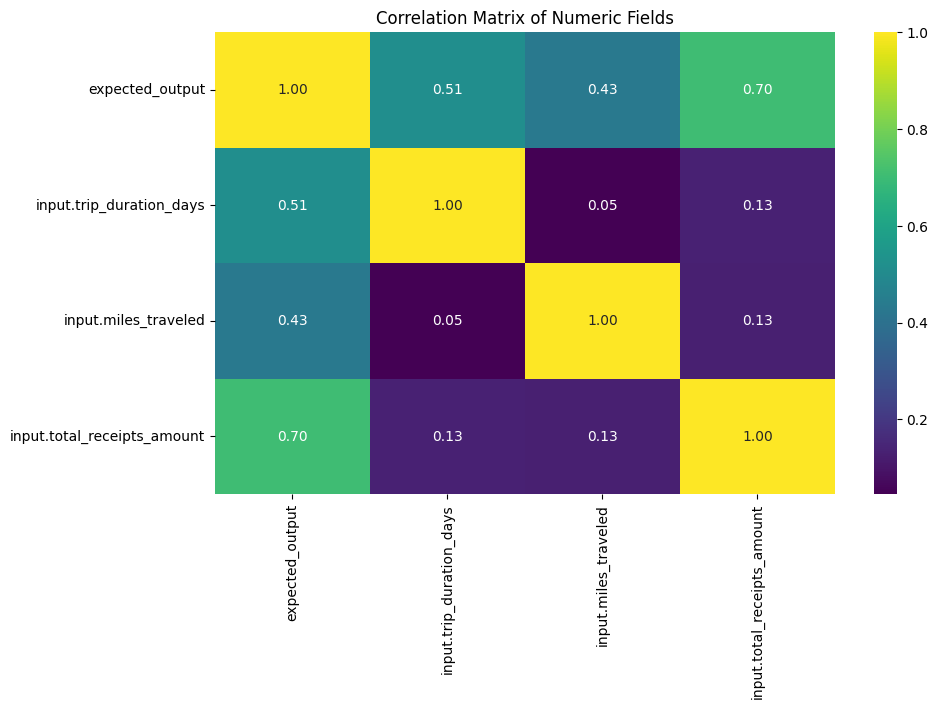

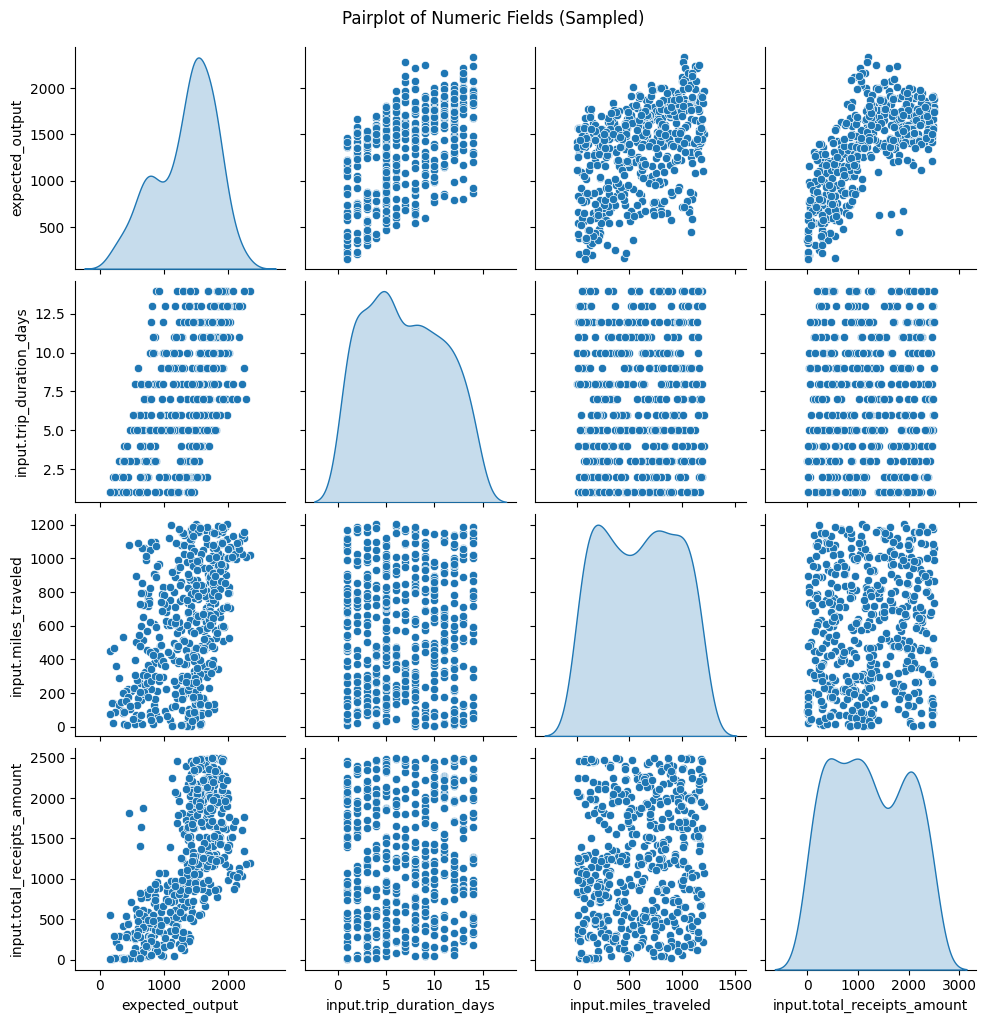

In [29]:
# --- Correlation & Relationship Analysis ---

features = ['expected_output', 'input.trip_duration_days', 'input.miles_traveled', 'input.total_receipts_amount']

# Select only numeric columns
numeric_df = df[features]

# Compute correlation matrix
corr_matrix = numeric_df.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="viridis")
plt.title("Correlation Matrix of Numeric Fields")
plt.show()

# Optional: Pairwise scatterplot (can be slow with large dataset)
sns.pairplot(numeric_df.sample(min(500, len(numeric_df))), diag_kind='kde')
plt.suptitle("Pairplot of Numeric Fields (Sampled)", y=1.02)
plt.show()


In [30]:
# --- Isolation Forest for Anomaly Detection ---

# Ensure no NaN values (required for sklearn models)
numeric_df_clean = numeric_df.dropna()

# Fit Isolation Forest
isof = IsolationForest(contamination=0.03, random_state=42)  # adjust contamination if needed
isof.fit(numeric_df_clean)

# Predict anomalies (-1 = anomaly, 1 = normal)
numeric_df_clean['is_anomaly_iforest'] = isof.predict(numeric_df_clean)
numeric_df_clean['is_anomaly_iforest'] = numeric_df_clean['is_anomaly_iforest'].apply(lambda x: 1 if x == -1 else 0)

# Merge anomaly flag back to original df
df['is_anomaly_iforest'] = 0
df.loc[numeric_df_clean.index, 'is_anomaly_iforest'] = numeric_df_clean['is_anomaly_iforest']

# Summary of anomalies
total_records = len(df)
anomaly_count = df['is_anomaly_iforest'].sum()
print(f"Isolation Forest flagged {anomaly_count} anomalies out of {total_records} records ({(anomaly_count/total_records)*100:.2f}%).")

df[df['is_anomaly_iforest'] == 1].head()


Isolation Forest flagged 30 anomalies out of 1000 records (3.00%).


,expected_output,input.trip_duration_days,input.miles_traveled,input.total_receipts_amount,is_anomaly_iforest
1,126.06,1,55.0,3.60,1
2,128.91,1,47.0,17.97,1
3,203.52,2,13.0,4.67,1
5,158.35,1,76.0,13.74,1
7,199.68,1,140.0,22.71,1


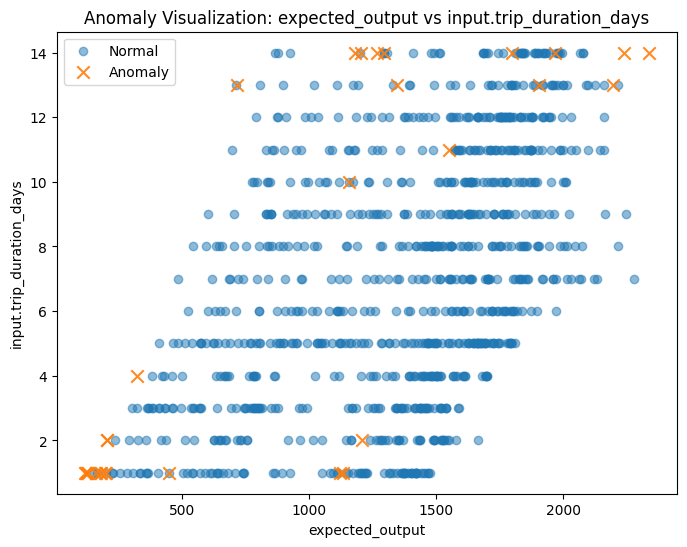

In [31]:
# --- Visualize anomalies on 2D scatter (choose two relevant numeric fields) ---

x_col = numeric_df.columns[0]  # EDIT these to match your two most important features
y_col = numeric_df.columns[1]

plt.figure(figsize=(8, 6))
plt.scatter(df[df['is_anomaly_iforest'] == 0][x_col], 
            df[df['is_anomaly_iforest'] == 0][y_col],
            alpha=0.5, label='Normal')

plt.scatter(df[df['is_anomaly_iforest'] == 1][x_col], 
            df[df['is_anomaly_iforest'] == 1][y_col],
            alpha=0.9, marker='x', s=80, label='Anomaly')

plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title(f"Anomaly Visualization: {x_col} vs {y_col}")
plt.legend()
plt.show()


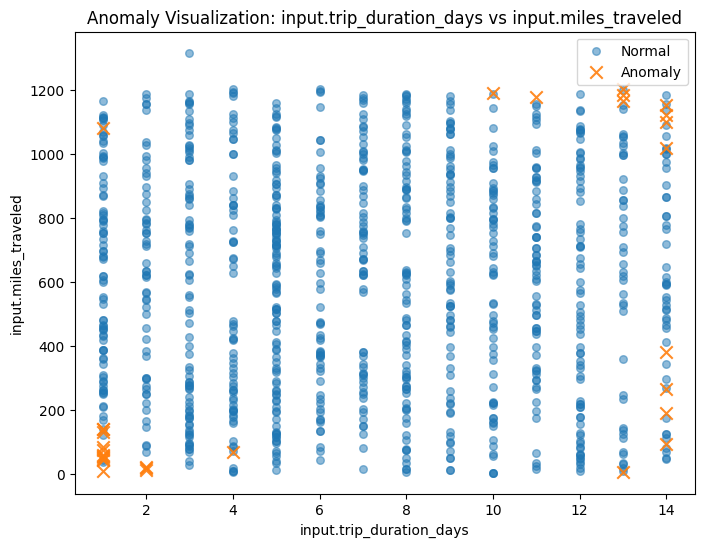

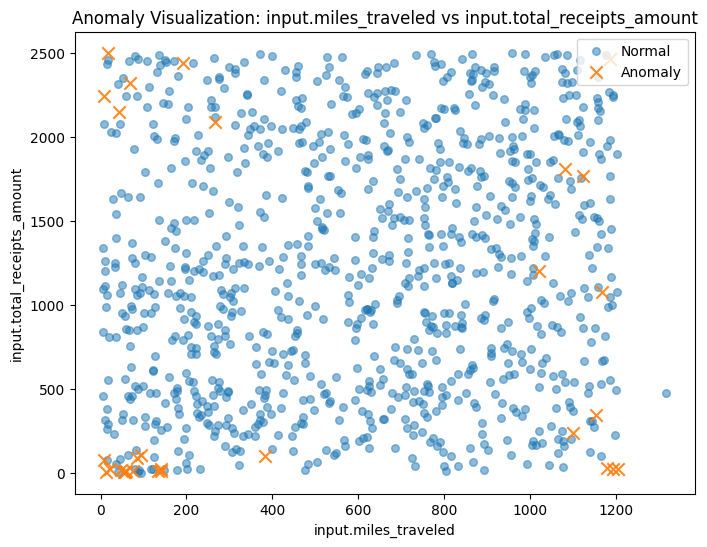

In [33]:
# --- Visualize anomalies pairwise across key metrics ---

# List of plot pairs
plot_pairs = [
    ("input.trip_duration_days", "input.miles_traveled"),
    ("input.miles_traveled", "input.total_receipts_amount")
]

for x_col, y_col in plot_pairs:
    plt.figure(figsize=(8, 6))
    
    # Plot normal points
    plt.scatter(df[df['is_anomaly_iforest'] == 0][x_col], 
                df[df['is_anomaly_iforest'] == 0][y_col],
                alpha=0.5, label='Normal', s=30)
    
    # Plot anomalies
    plt.scatter(df[df['is_anomaly_iforest'] == 1][x_col], 
                df[df['is_anomaly_iforest'] == 1][y_col],
                alpha=0.9, marker='x', s=80, label='Anomaly')
    
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f"Anomaly Visualization: {x_col} vs {y_col}")
    plt.legend()
    plt.show()


In [34]:
# --- Anomaly Summary Table combining IQR, Z-Score, and Isolation Forest flags ---

import pandas as pd
from scipy.stats import zscore

# Prepare dataframe for anomaly counting
summary_data = []

# Only evaluate numeric columns
for col in numeric_df.columns:
    series = df[col].dropna()

    # IQR method
    Q1, Q3 = series.quantile(0.25), series.quantile(0.75)
    IQR = Q3 - Q1
    iqr_mask = (series < (Q1 - 1.5 * IQR)) | (series > (Q3 + 1.5 * IQR))
    iqr_outliers = iqr_mask.sum()

    # Z-score method
    z_scores = zscore(series)
    z_mask = abs(z_scores) > 3  # threshold = 3
    z_outliers = z_mask.sum()

    # Add to summary list
    summary_data.append({
        "Feature": col,
        "IQR Outliers": iqr_outliers,
        "Z-Score Outliers": z_outliers,
        "Isolation Forest Outliers": df[(df['is_anomaly_iforest'] == 1) & (df[col].notna())].shape[0]
    })

# Create summary table
anomaly_summary_df = pd.DataFrame(summary_data)

# Sort by most anomalies detected (descending)
anomaly_summary_df = anomaly_summary_df.sort_values("Isolation Forest Outliers", ascending=False)

# Display result
print("\n🔍 Anomaly Detection Summary Table:")
display(anomaly_summary_df)



🔍 Anomaly Detection Summary Table:


,Feature,IQR Outliers,Z-Score Outliers,Isolation Forest Outliers
0,expected_output,0,0,30
1,input.trip_duration_days,0,0,30
2,input.miles_traveled,0,0,30
3,input.total_receipts_amount,0,0,30


In [35]:
# Filter for records where trip duration is 0 but miles were traveled
anomaly_zero_duration = df[(df['input.trip_duration_days'] == 0) & (df['input.miles_traveled'] > 0)]
print(f"Found {len(anomaly_zero_duration)} records with 0 trip duration but miles traveled > 0")
display(anomaly_zero_duration)



Found 0 records with 0 trip duration but miles traveled > 0


,expected_output,input.trip_duration_days,input.miles_traveled,input.total_receipts_amount,is_anomaly_iforest


In [36]:
anomaly_high_receipts = df[df['input.total_receipts_amount'] > df['expected_output'] * 2]
print(f"Found {len(anomaly_high_receipts)} records with total receipts amount > 2x expected output")
display(anomaly_high_receipts)

Found 11 records with total receipts amount > 2x expected output


,expected_output,input.trip_duration_days,input.miles_traveled,input.total_receipts_amount,is_anomaly_iforest
83,162.18,1,451.00,555.49,0
114,511.23,5,195.73,1228.49,0
151,322.00,4,69.00,2321.49,1
243,418.17,4,286.00,1063.49,0
246,1206.95,2,18.00,2503.46,1
263,1120.22,1,9.00,2246.28,1
547,631.81,8,482.00,1411.49,0
637,1209.08,1,170.00,2452.85,0
683,644.69,8,795.00,1645.99,0
710,669.85,5,516.00,1878.49,0


In [37]:
# Calculate expected amount per mile from the data
expected_amount_per_mile = (df['input.total_receipts_amount'] / df['input.miles_traveled']).median()
print(f"Median amount per mile: ${expected_amount_per_mile:.2f}")

# Find records where receipts per mile exceed 3x the median
anomalies_unrealistic_receipts = df[(df['input.miles_traveled'] > 0) & 
                                    (df['input.total_receipts_amount'] / df['input.miles_traveled'] > expected_amount_per_mile * 3)]
print(f"Found {len(anomalies_unrealistic_receipts)} records with unrealistic receipts per mile (>3x median)")
display(anomalies_unrealistic_receipts)

Median amount per mile: $1.95
Found 155 records with unrealistic receipts per mile (>3x median)


,expected_output,input.trip_duration_days,input.miles_traveled,input.total_receipts_amount,is_anomaly_iforest
21,1443.96,5,173.00,1337.90,0
111,666.59,6,72.85,457.75,0
114,511.23,5,195.73,1228.49,0
121,1499.24,8,161.15,1230.37,0
127,1050.25,5,66.13,848.03,0
...,...,...,...,...,...
967,1555.48,13,11.00,1114.96,0
973,1372.31,9,14.00,1057.38,0
975,1561.20,6,135.00,2488.22,0
979,1716.13,13,145.00,2202.42,0
